In [1]:
# Importing the required libraries
import pandas as pd
import os
import numpy as np

In [2]:
# Importing the dataset
df = pd.read_csv('https://raw.githubusercontent.com/Athena75/IBM-Customer-Value-Dashboarding/main/data/Customer-Value-Analysis.csv', index_col = 'Customer')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, BU79786 to Y167826
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          9134 non-null   object 
 1   Customer Lifetime Value        9134 non-null   float64
 2   Response                       9134 non-null   object 
 3   Coverage                       9134 non-null   object 
 4   Education                      9134 non-null   object 
 5   Effective To Date              9134 non-null   object 
 6   EmploymentStatus               9134 non-null   object 
 7   Gender                         9134 non-null   object 
 8   Income                         9134 non-null   int64  
 9   Location Code                  9134 non-null   object 
 10  Marital Status                 9134 non-null   object 
 11  Monthly Premium Auto           9134 non-null   int64  
 12  Months Since Last Claim        9134 non-null

In [4]:
# Checking the dataset for any missing values
df.isnull().sum()

State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

<AxesSubplot:>

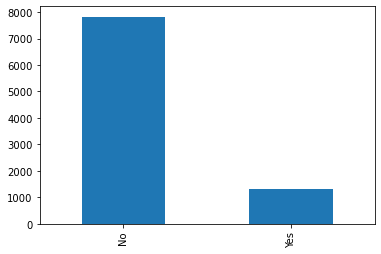

In [5]:
# Checking the distribution of the target variable
df['Response'].value_counts().plot(kind = 'bar')

In [6]:
# Splitting the target, categorical and numerical variables
X = df.drop(['Response'], axis = 1)
Y = df.Response.apply(lambda X : 0 if X == 'No' else 1)

catgs = [var for var, var_type in X.dtypes.items() if var_type == 'object']
numls = [var for var in X.columns if var not in catgs]

In [7]:
# Creating a Custom Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.compose import ColumnTransformer

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__(self, get_feature_names):
        self.get_feature_names = get_feature_names 
           
    def fit(self, X, Y = None):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, Y = None):
        return X[self.get_feature_names].values 


#Defining the steps in the categorical pipeline 
catg_pipeline = Pipeline([('catg_selector', FeatureSelector(catgs)),
                          ('one_hot_encoder', OneHotEncoder(sparse = False) ) ] )
    
#Defining the steps in the numerical pipeline     
numl_pipeline = Pipeline([
        ('num_selector', FeatureSelector(numls)),
        ('std_scaler', StandardScaler()),
    ])


#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion(transformer_list = [('numl_pipeline', numl_pipeline),
                                                ('catg_pipeline', catg_pipeline)])

In [8]:
# Splitting and apply data transformation
from sklearn.model_selection import train_test_split, cross_validate
X_train,  X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 123)
#fit and transform the custom transformer in train
X_train_processed = full_pipeline.fit_transform(X_train)
# transform the test with the trainef tansformer
X_test_processed = full_pipeline.transform(X_test)

In [9]:
print('transformed training dataset shape', X_train_processed.shape)
print('transformed training dataset shape', X_test_processed.shape)

transformed training dataset shape (7307, 122)
transformed training dataset shape (1827, 122)


In [10]:
from joblib import dump, load
dump(full_pipeline, f'./model/transformer.joblib')

['./model/transformer.joblib']

In [11]:
import pickle
catg_step = full_pipeline.get_params()['transformer_list'][-1][-1]
ohe = catg_step.steps[-1][-1]
ohe_categories =dict(zip(catgs, ohe.categories_))
output_path = f'./model/ohe_categories.pkl'
with open(output_path, 'wb') as output:
        pickle.dump(ohe_categories, output, pickle.HIGHEST_PROTOCOL)

In [12]:
# Model Selection
%time
from sklearn.metrics import log_loss
from joblib import dump, load
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.linear_model import SGDClassifier

names = ["Nearest Neighbors", "XGBoost", "Random Forest"]

classifiers = [
    KNeighborsClassifier(3),
    GradientBoostingClassifier(),
    RandomForestClassifier()]

scores = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    # Cross val prediction    
    cv_preds = cross_val_predict(clf, X_train_processed, Y_train, method='predict_proba')
    cv_score = log_loss(Y_train, cv_preds)
    
    # holdout data 
    clf.fit(X_train_processed, Y_train)
    hd_preds = clf.predict_proba(X_test_processed)
    hd_score = log_loss(Y_test, hd_preds)
    
    # append the scores
    scores[name] = [cv_score, hd_score]
    #store the model
    dump(clf, f'./model/{name}.joblib') 

Wall time: 0 ns


In [13]:
for model, perf in scores.items():
    print(f'{model} => CV_AUC : {perf[0]}, Holdout_AUC:{perf[1]}')

Nearest Neighbors => CV_AUC : 0.6180761729528248, Holdout_AUC:0.8228086510627445
XGBoost => CV_AUC : 0.26896754671270173, Holdout_AUC:0.2453750337029017
Random Forest => CV_AUC : 0.10136498084015419, Holdout_AUC:0.076161407715739


In [14]:
# Model Tuning
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = [
    {'n_estimators': [100, 200]},
    {'n_estimators': [50, 100, 200], 'max_features': ['log2']},
    {'bootstrap': [False], 'n_estimators': [150, 300], 'max_features': [2, 4]},
]
# about how to use the scorer strategy for the grid search:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
scorer = make_scorer(log_loss)

RF = RandomForestClassifier()
grid_search = GridSearchCV(RF, param_grid, cv = 5,
                           scoring = scorer,
                           return_train_score = True)

grid_search.fit(X_train_processed, Y_train)

UsageError: Line magic function `%%time` not found.


In [ ]:
grid_search.best_params_

In [ ]:
# Cross Validation
sk_best = grid_search.best_estimator_

# Cross val prediction    
cv_preds = cross_val_predict(sk_best, 
                             X_train_processed, Y_train, 
                             method = 'predict_proba')
best_cv_score = log_loss(Y_train, cv_preds)

# holdout data 
sk_best.fit(X_train_processed, Y_train)
hd_preds = sk_best.predict_proba(X_test_processed)
best_hd_score = log_loss(Y_test, hd_preds)


#store the model
dump(sk_best,f'./model/best.joblib') 

In [ ]:
print(f'best => CV_AUC : {best_cv_score}, Holdout_AUC:{best_hd_score}')

In [ ]:
# New Prediction
# example of new enty
new_entry = X_test.loc[X_test.index[-1]].to_frame()
# pass it throug the pipeline
new_entry_processed = full_pipeline.transform(new_entry.T)
# make prediction
sk_best.predict_proba(new_entry_processed)

In [ ]:
# take the argmax
sk_best.predict(new_entry_processed)

In [ ]:
# Classification Performances
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Cross val prediction    
cv_one_preds = cross_val_predict(sk_best, 
                             X_train_processed, Y_train, 
                             method='predict')

In [ ]:
perf = {'accuracy' : accuracy_score(Y_train, cv_one_preds),
       'precision': precision_score(Y_train, cv_one_preds),
       'recall' : recall_score(Y_train, cv_one_preds),
       'f1_score': f1_score(Y_train, cv_one_preds)}

# persist the result
output_path = f'./model/sk_best_performances.pkl'
with open(output_path, 'wb') as output:
        pickle.dump(perf, output, pickle.HIGHEST_PROTOCOL)